In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers 
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [77]:
route_distances = pd.read_csv('Data/Traffic02/PeMSD7_W_228.csv', header=None).to_numpy()

speeds_array = pd.read_csv('Data/Traffic02/PeMSD7_V_228.csv', header=None).to_numpy()

print(f"route_distances shape={route_distances.shape}")
print(f"speeds_array shape={speeds_array.shape}")

route_distances shape=(228, 228)
speeds_array shape=(12672, 228)


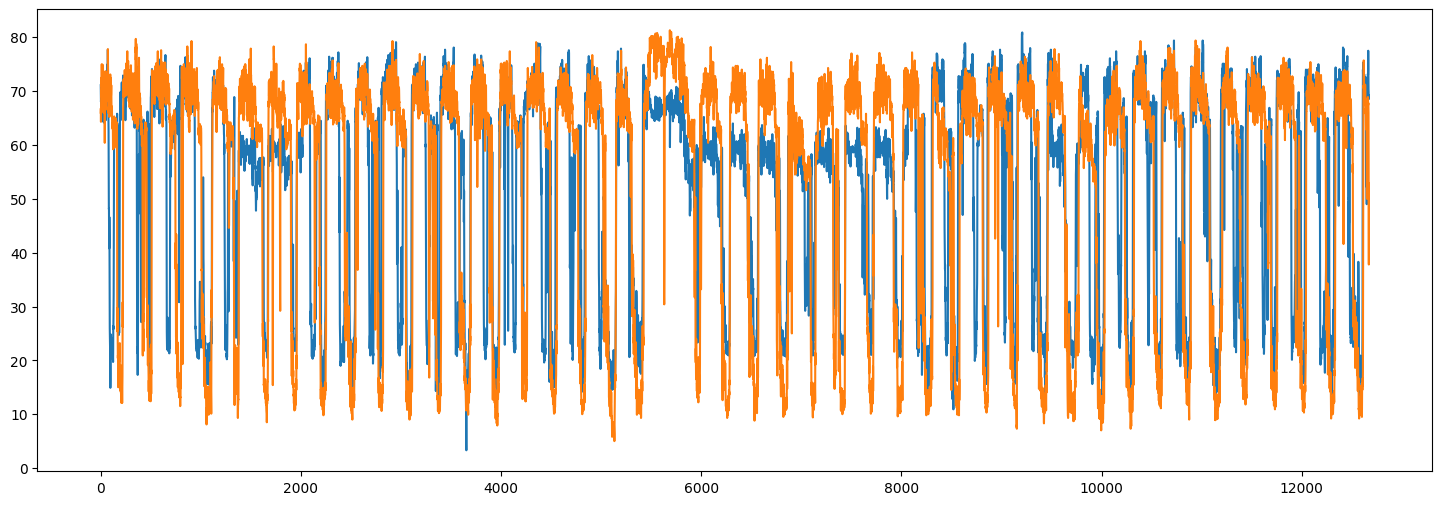

In [80]:
x1 = speeds_array[:, 0]
x2 = speeds_array[:, 1]

plt.figure(figsize=(18,6))
plt.plot(x1)
plt.plot(x2)

In [98]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(x1.reshape(-1, 1))

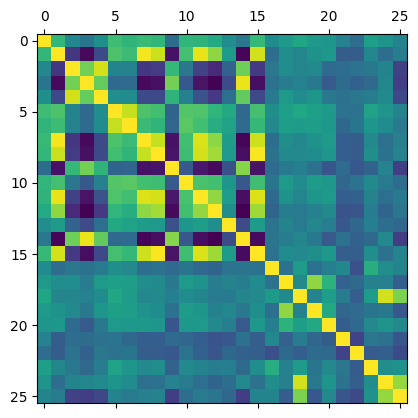

In [81]:
plt.matshow(np.corrcoef(speeds_array[:, :26].T), 0)

In [82]:
def preprocess(data: np.ndarray, train_size: float, val_size: float):

    num_time_steps = data.shape[0]

    num_train, num_val = (
        int(num_time_steps * train_size),
        int(num_time_steps * val_size)
    )

    train_arr = data[:num_train]
    mean, std = train_arr.mean(axis=0), train_arr.std(axis=0)

    train_arr = (train_arr - mean)/std
    val_arr = (data[num_train : (num_train + num_val)] - mean)/std
    test_arr = (data[(num_train + num_val):] - mean)/std

    return train_arr, val_arr, test_arr

In [83]:
train_size, val_size = 0.5, 0.2
train_array, val_array, test_array = preprocess(x1, train_size, val_size)
print(f"train set size: {train_array.shape}")
print(f"validation set size: {val_array.shape}")
print(f"test set size: {test_array.shape}")

train set size: (6336,)
validation set size: (2534,)
test set size: (3802,)


In [86]:
batch_size = 64
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False


def create_dataset(dataset, input_sequence_length=1):
 dataX, dataY = [], []
 for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back)]
    dataX.append(a)
    dataY.append(dataset[i + look_back])
 return np.array(dataX), np.array(dataY)


In [87]:
trainX, trainY = create_dataset(train_array, input_sequence_length)
valX, valY = create_dataset(val_array, input_sequence_length)
testX, testY = create_dataset(test_array, input_sequence_length)

In [93]:
type(trainX)

numpy.ndarray

In [91]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
valX = np.reshape(valX, (valX.shape[0], 1, valX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [94]:
# create and fit the LSTM network
with tf.device('GPU'):
    model = keras.Sequential()
    model.add(layers.LSTM(4, input_shape=(1, input_sequence_length)))
    model.add(layers.Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100


/home/guilherme/venvs/DLenv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6323/6323 - 10s - 2ms/step - loss: 0.1022
Epoch 2/100
6323/6323 - 9s - 1ms/step - loss: 0.0274
Epoch 3/100
6323/6323 - 10s - 2ms/step - loss: 0.0248
Epoch 4/100
6323/6323 - 9s - 1ms/step - loss: 0.0234
Epoch 5/100
6323/6323 - 10s - 2ms/step - loss: 0.0227
Epoch 6/100
6323/6323 - 9s - 1ms/step - loss: 0.0220
Epoch 7/100
6323/6323 - 9s - 1ms/step - loss: 0.0218
Epoch 8/100
6323/6323 - 9s - 1ms/step - loss: 0.0216
Epoch 9/100
6323/6323 - 9s - 1ms/step - loss: 0.0217
Epoch 10/100
6323/6323 - 9s - 1ms/step - loss: 0.0216
Epoch 11/100
6323/6323 - 9s - 1ms/step - loss: 0.0215
Epoch 12/100
6323/6323 - 10s - 2ms/step - loss: 0.0213
Epoch 13/100
6323/6323 - 10s - 2ms/step - loss: 0.0213
Epoch 14/100
6323/6323 - 10s - 2ms/step - loss: 0.0213
Epoch 15/100
6323/6323 - 9s - 1ms/step - loss: 0.0211
Epoch 16/100
6323/6323 - 9s - 1ms/step - loss: 0.0210
Epoch 17/100
6323/6323 - 9s - 1ms/step - loss: 0.0211
Epoch 18/100
6323/6323 - 10s - 2ms/step - loss: 0.0211
Epoch 19/100
6323/6323 - 10s - 2ms/step - 

In [99]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
Train Score: 11.21 RMSE
Test Score: 13.23 RMSE


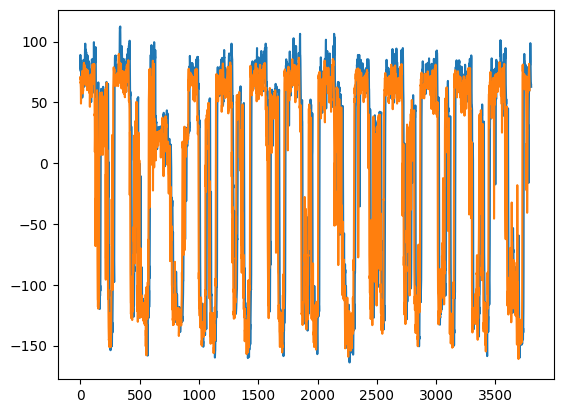

In [110]:
plt.plot(scaler.inverse_transform(test_array.reshape(-1, 1)))
plt.plot(testPredict)